In [1]:
from __future__ import annotations

import pickle
from collections import OrderedDict
from pathlib import Path

import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
from hist import Hist

from boostedhh.hh_vars import data_key, years
from bbtautau.postprocessing.datacardHelpers import sum_templates
from bbtautau.postprocessing.postprocessing import shape_vars
from bbtautau.postprocessing import plotting
from bbtautau.postprocessing import utils as putils
from bbtautau.postprocessing.Samples import BGS, CHANNELS

from bbtautau.userConfig import MAIN_DIR

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
folder = "090325_newABCD_Bmin8"

plot_dir = MAIN_DIR / "plots/PostFit" / folder
plot_dir.mkdir(exist_ok=True, parents=True)

# years = ["2022"]

In [4]:
plot_dir.resolve()

PosixPath('/home/users/haoyang/bbtautau_sen/src/plots/PostFit/090325_newABCD_Bmin8')

In [5]:
file = uproot.open(f"/home/users/haoyang/bbtautau_sen/src/bbtautau/cards/{folder}/FitShapes.root")
templates_dir = f"/home/users/haoyang/bbtautau_sen/src/bbtautau/templates/{folder}"
csv_dir_path = "/home/users/haoyang/bbtautau_sen/plots/test_sel_samples/plots/SensitivityStudy/2025-09-03/full_presel/10July25_leptons"

In [6]:
# sig_templates_dir = Path(f"templates/25Apr23/{CHANNEL.key}")
# bg_templates_dir = Path(f"templates/25Apr23/{CHANNEL.key}")

# templates_dict = {}
# for year in years:
#     with (sig_templates_dir / f"{year}_templates.pkl").open("rb") as f:
#         templates_dict[year] = pickle.load(f)

# sig_pre_templates = sum_templates(templates_dict, years)

# templates_dict = {}
# for year in years:
#     with (bg_templates_dir / f"{year}_templates.pkl").open("rb") as f:
#         templates_dict[year] = pickle.load(f)

# bg_pre_templates = sum_templates(templates_dict, years)

In [7]:
def get_pre_templates(templates_dir):
    templates_dict = {}
    for year in years:
        with (templates_dir / f"{year}_templates.pkl").open("rb") as f:
            templates_dict[year] = pickle.load(f)

    return sum_templates(templates_dict, years)

In [8]:
workspace_data_key = "data_obs"

# (name in templates, name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("qcddy", "CMS_bbtautau_boosted_qcd_datadriven"),
        ("ttbarsl", "ttbarsl"),
        ("ttbarll", "ttbarll"),
        ("ttbarhad", "ttbarhad"),
        # ("dyjets", "dyjets"),
        ("wjets", "wjets"),
        ("zjets", "zjets"),
        ("hbb", "hbb"),
        (data_key, workspace_data_key),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}

sig_keys = ["bbtt"]

# pbg_keys = [bk for bk in bg_keys if bk not in ["Diboson", "Hbb", "HWW"]]
pbg_keys = ["qcddy", "ttbarhad", "ttbarsl", "ttbarll", "wjets", "zjets", "hbb"]
samples = pbg_keys + sig_keys + [data_key]

In [12]:
bmin = 8
use_bdt=True

In [13]:
shapes = {
    "prefit": "Pre-Fit",
    # "shapes_fit_s": "S+B Post-Fit",
    "postfit": "B-only Post-Fit",
}

from copy import deepcopy
import pandas as pd

selection_regions = {}
for channel in CHANNELS.values():

    channel = deepcopy(channel)
    csv_dir = Path(f"{csv_dir_path}/{channel.key}")

    # Look for any FOM-specific CSV files
    csv_files = list(csv_dir.glob("*_opt_results_*.csv"))

    if len(csv_files) == 0:
        raise ValueError(f"No sensitivity CSV files found in {csv_dir}")

    # Take the first CSV file found and extract FOM name
    csv_file = sorted(csv_files)[0]  # Sort for reproducible behavior
    print(f"Reading CSV: {csv_file}")

    # Extract FOM name from filename like "2022_2022EE_opt_results_2sqrtB_S_var.csv"
    if "_opt_results_" in csv_file.name:
        fom_name = csv_file.name.split("_opt_results_")[1].replace(".csv", "")
    else:
        fom_name = "unknown"

    # Read as simple CSV (no multi-level headers)
    opt_results = pd.read_csv(csv_file, index_col=0)
    print(f"Using FOM: {fom_name}")
    print(f"Available B_min values: {opt_results.columns.tolist()}")

    # Check if the target Bmin column exists
    target_col = f"Bmin={bmin}"
    if target_col not in opt_results.columns:
        raise ValueError(
            f"B_min={bmin} not found in CSV. Available: {opt_results.columns.tolist()}"
        )

    # update the CHANNEL cuts
    channel.txbb_cut = float(opt_results.loc["Cut_Xbb", target_col])
    if use_bdt:
        channel.txtt_BDT_cut = float(opt_results.loc["Cut_Xtt", target_col])
    else:
        channel.txtt_cut = float(opt_results.loc["Cut_Xtt", target_col])

    print(
        f"Updated TXbb and Txtt cuts to {channel.txbb_cut} and {channel.txtt_cut if not use_bdt else channel.txtt_BDT_cut} for {channel.key}"
    )

    selection_regions[f"{channel.key}pass"] = f"{channel.label} Pass"
    selection_regions[f"{channel.key}fail"] = f"{channel.label} Fail"

Reading CSV: /home/users/haoyang/bbtautau_sen/plots/test_sel_samples/plots/SensitivityStudy/2025-09-03/full_presel/10July25_leptons/hh/2022_2022EE_2023_2023BPix_opt_results_2sqrtB_S_var.csv
Using FOM: 2sqrtB_S_var
Available B_min values: ['Bmin=1', 'Bmin=5', 'Bmin=8', 'Bmin=12']
Updated TXbb and Txtt cuts to 0.7673469387755102 and 0.9693877551020408 for hh
Reading CSV: /home/users/haoyang/bbtautau_sen/plots/test_sel_samples/plots/SensitivityStudy/2025-09-03/full_presel/10July25_leptons/hm/2022_2022EE_2023_2023BPix_opt_results_2sqrtB_S_var.csv
Using FOM: 2sqrtB_S_var
Available B_min values: ['Bmin=1', 'Bmin=5', 'Bmin=8', 'Bmin=12']
Updated TXbb and Txtt cuts to 0.8224489795918367 and 0.9571428571428571 for hm
Reading CSV: /home/users/haoyang/bbtautau_sen/plots/test_sel_samples/plots/SensitivityStudy/2025-09-03/full_presel/10July25_leptons/he/2022_2022EE_2023_2023BPix_opt_results_2sqrtB_S_var.csv
Using FOM: 2sqrtB_S_var
Available B_min values: ['Bmin=1', 'Bmin=5', 'Bmin=8', 'Bmin=12']
Up

In [14]:
file.keys()

['hefail_prefit;1',
 'hefail_prefit/CMS_bbtautau_boosted_qcd_datadriven;1',
 'hefail_prefit/TotalBkg;1',
 'hefail_prefit/TotalProcs;1',
 'hefail_prefit/TotalSig;1',
 'hefail_prefit/data_obs;1',
 'hefail_prefit/hbb;1',
 'hefail_prefit/ttbarhad;1',
 'hefail_prefit/ttbarll;1',
 'hefail_prefit/ttbarsl;1',
 'hefail_prefit/wjets;1',
 'hefail_prefit/zjets;1',
 'hefailMCBlinded_prefit;1',
 'hefailMCBlinded_prefit/CMS_bbtautau_boosted_qcd_datadriven;1',
 'hefailMCBlinded_prefit/TotalBkg;1',
 'hefailMCBlinded_prefit/TotalProcs;1',
 'hefailMCBlinded_prefit/TotalSig;1',
 'hefailMCBlinded_prefit/data_obs;1',
 'hefailMCBlinded_prefit/hbb;1',
 'hefailMCBlinded_prefit/ttbarhad;1',
 'hefailMCBlinded_prefit/ttbarll;1',
 'hefailMCBlinded_prefit/ttbarsl;1',
 'hefailMCBlinded_prefit/wjets;1',
 'hefailMCBlinded_prefit/zjets;1',
 'hepass_prefit;1',
 'hepass_prefit/CMS_bbtautau_boosted_qcd_datadriven;1',
 'hepass_prefit/TotalBkg;1',
 'hepass_prefit/TotalProcs;1',
 'hepass_prefit/TotalSig;1',
 'hepass_prefit/d

In [15]:
hists = {}
bgerrs = {}

for shape in shapes:
    print(shape)
    hists[shape] = {
        region: Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }
    bgerrs[shape] = {}

    for region in selection_regions:
        h = hists[shape][region]
        templates = file[f"{region}_{shape}"]
        for key, file_key in hist_label_map_inverse.items():
            if key != data_key:
                if file_key not in templates:
                    print(f"No {key} in {region}")
                    continue

                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = templates[file_key].values()

        # # if key not in fit output, take from templates
        # for key in pbg_keys:
        #     if key not in hist_label_map_inverse:
        #         data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
        #         h.view(flow=False)[data_key_index, :] = bg_pre_templates[region][key, ...].values()

        # if key not in fit output, take from templates
        for key in sig_keys:
            if key not in hist_label_map_inverse:
                sig_pre_templates = get_pre_templates(Path(f"{templates_dir}/{region[:2]}"))
                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = sig_pre_templates[region[2:]][
                    key + region[:2], ...
                ].values()

        data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
        h.view(flow=False)[data_key_index, :] = np.nan_to_num(
            templates[hist_label_map_inverse[data_key]].values()
        )

        bgerrs[shape][region] = np.minimum(
            templates["TotalBkg"].errors(), templates["TotalBkg"].values()
        )

prefit
No wjets in hhpass
No wjets in hepass
No zjets in hepass
postfit
No wjets in hhpass
No wjets in hepass
No zjets in hepass


In [16]:
# if not unblinded:
#     for shapeh in hists.values():
#         for region, h in shapeh.items():
#             if region != "fail":
#                 utils.blindBins(h, [100, 150], data_key, axis=0)

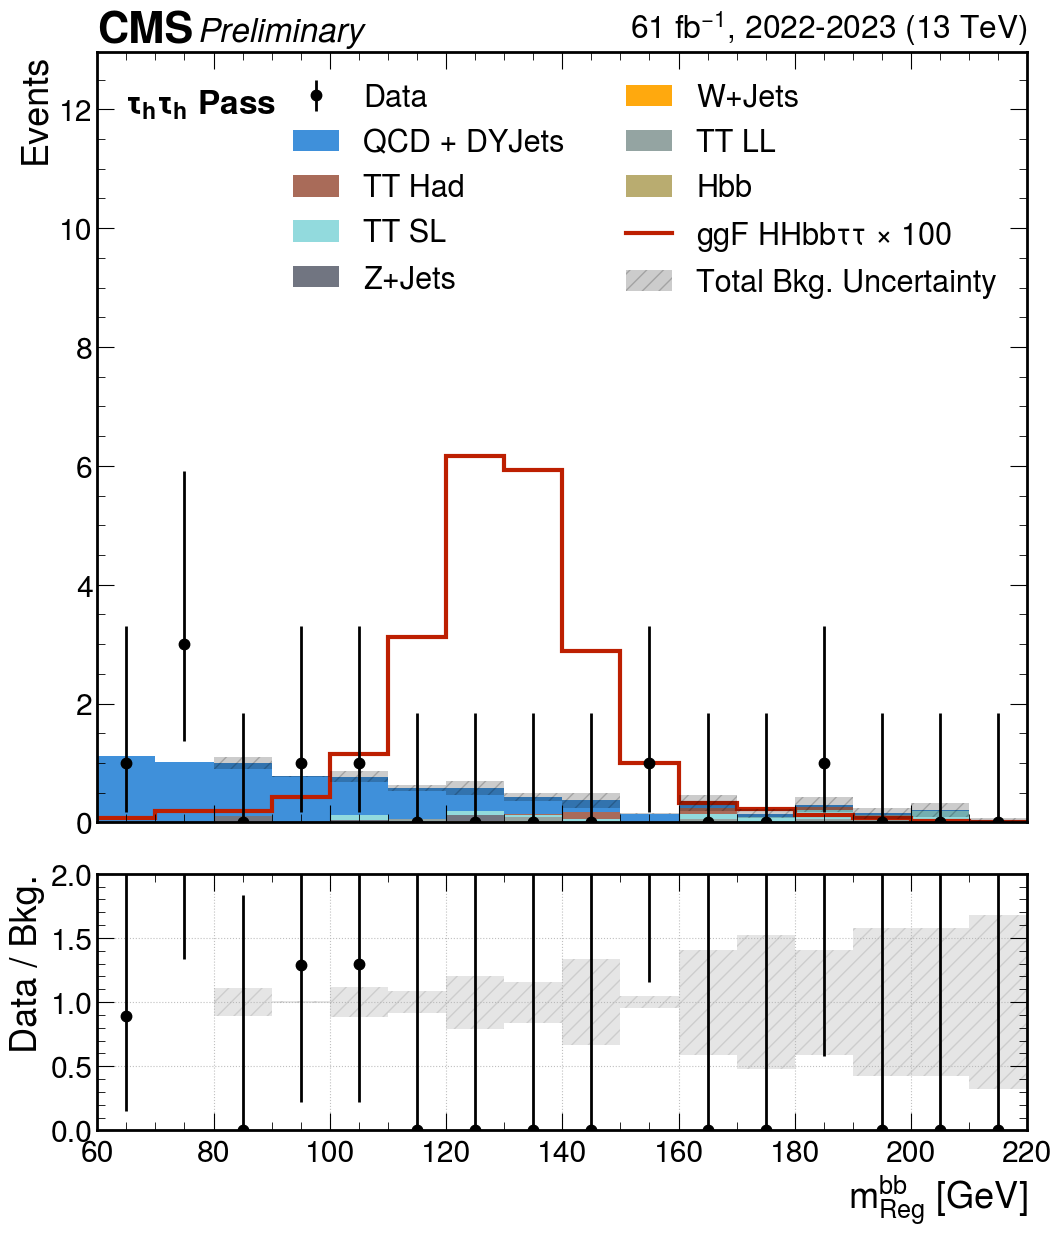

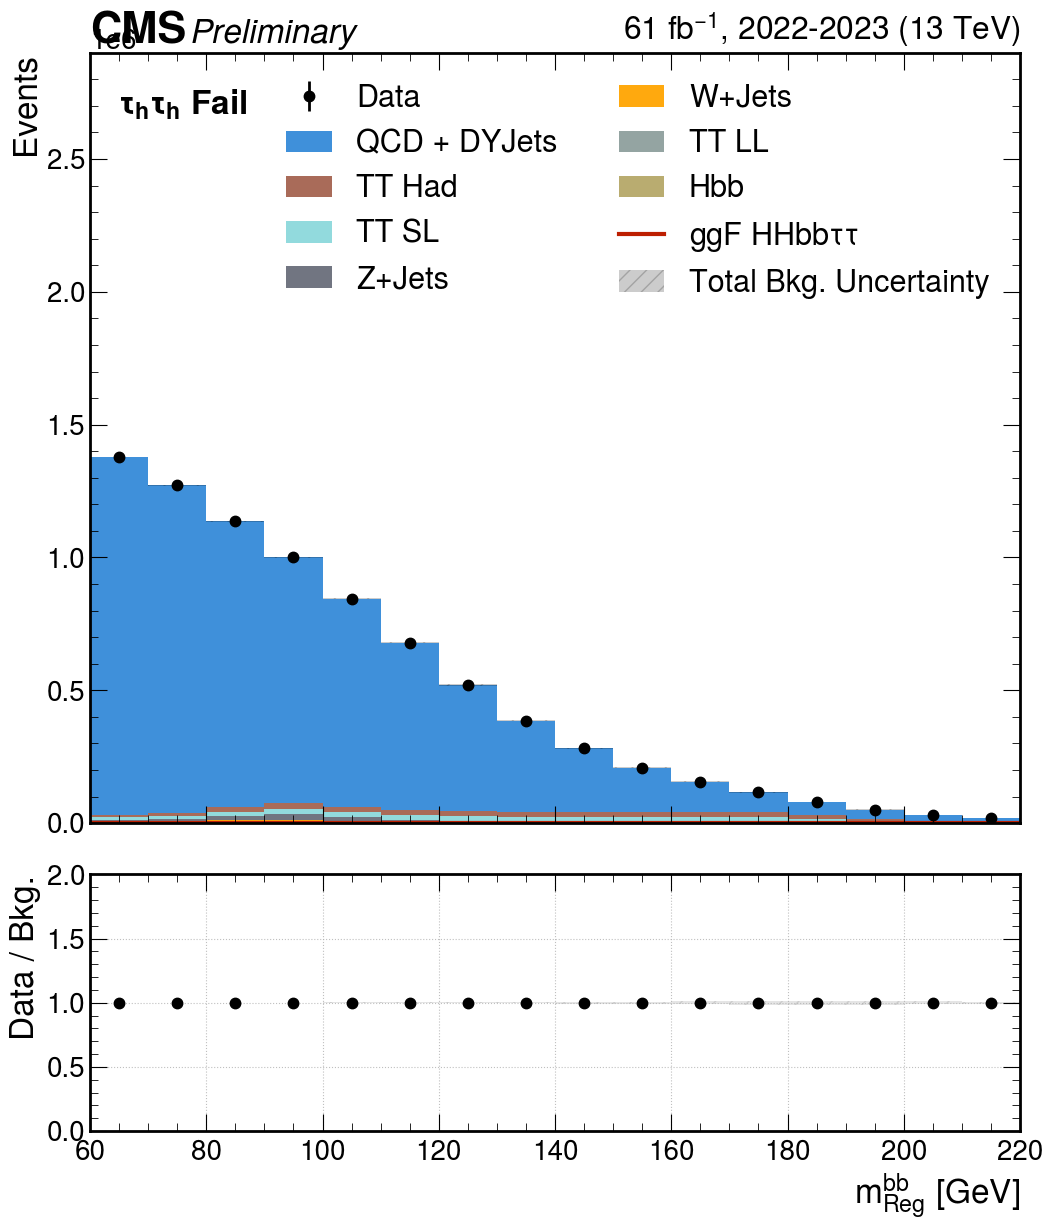

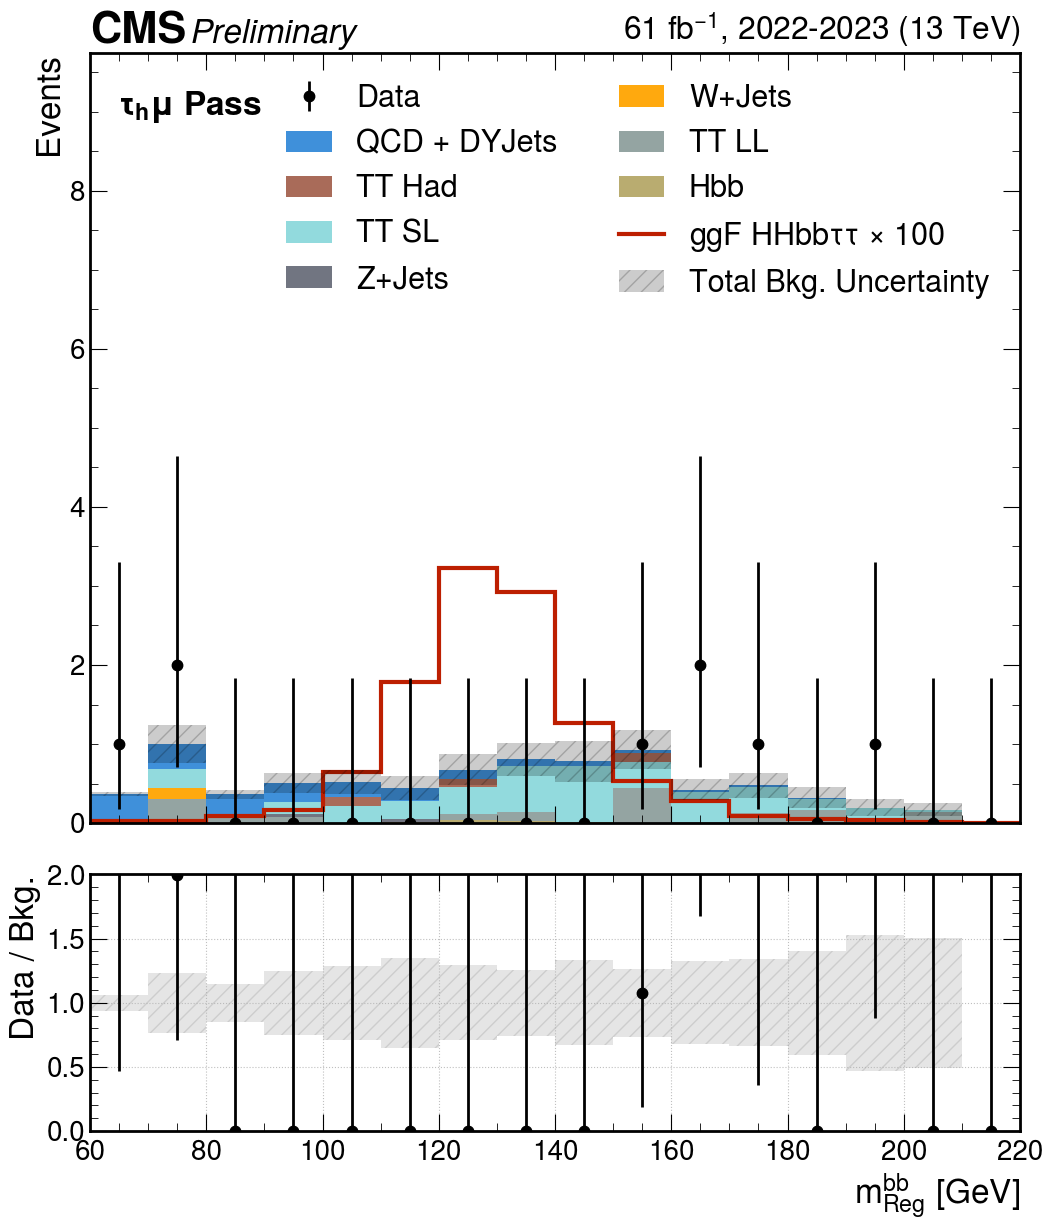

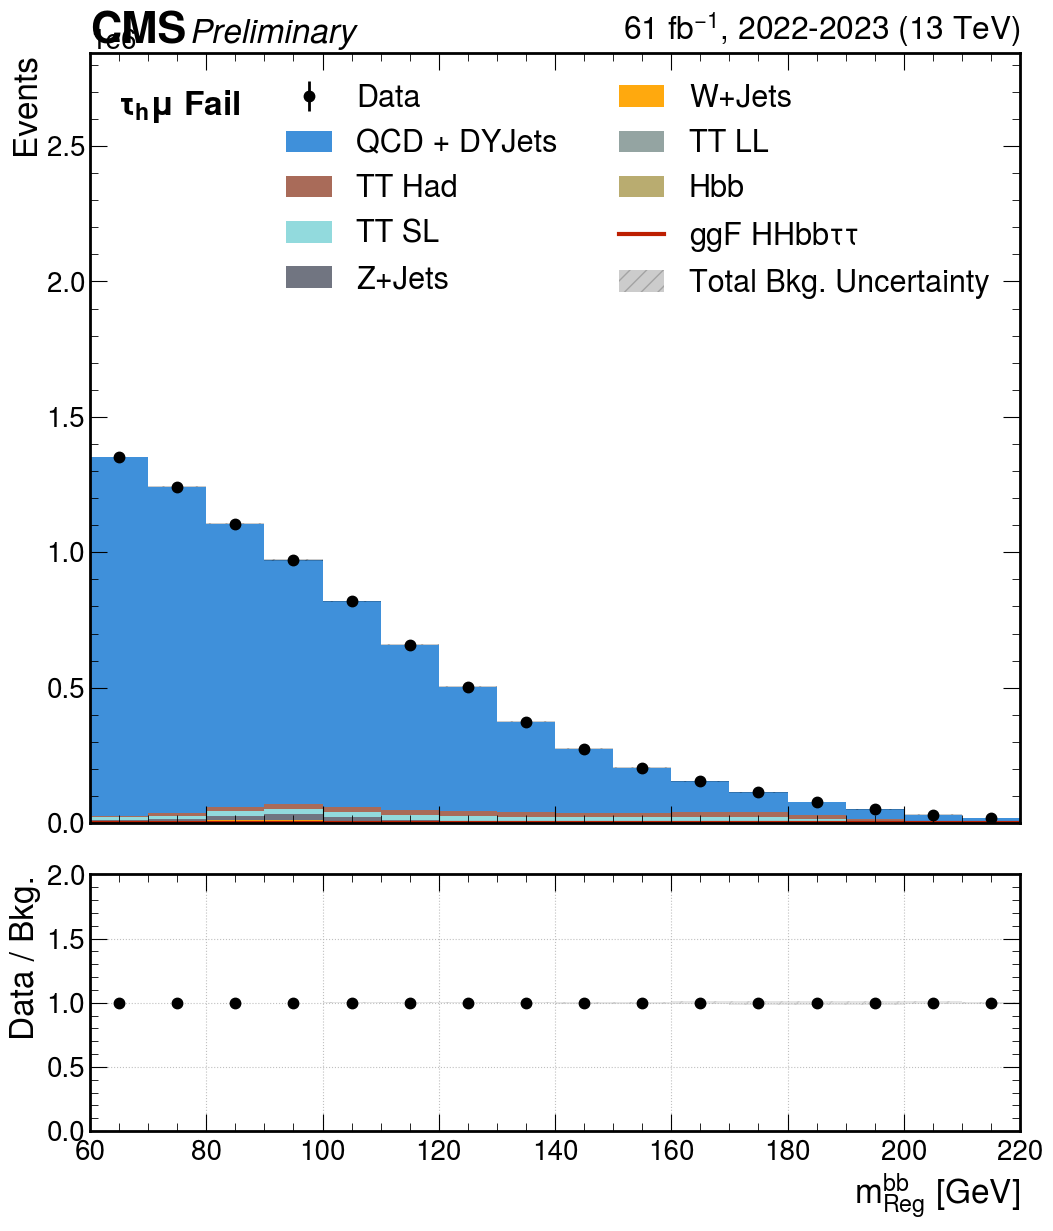

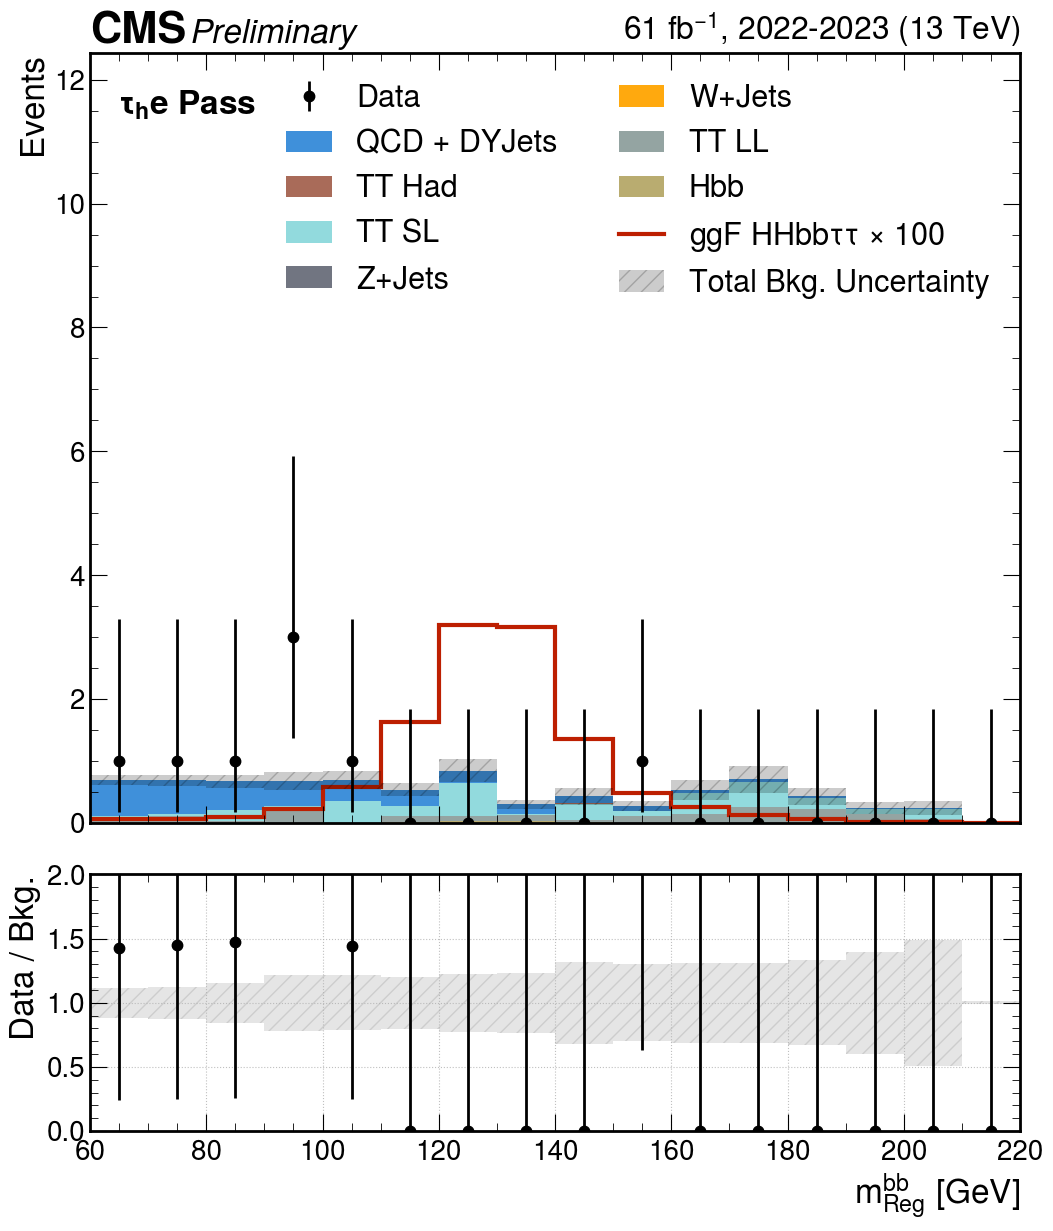

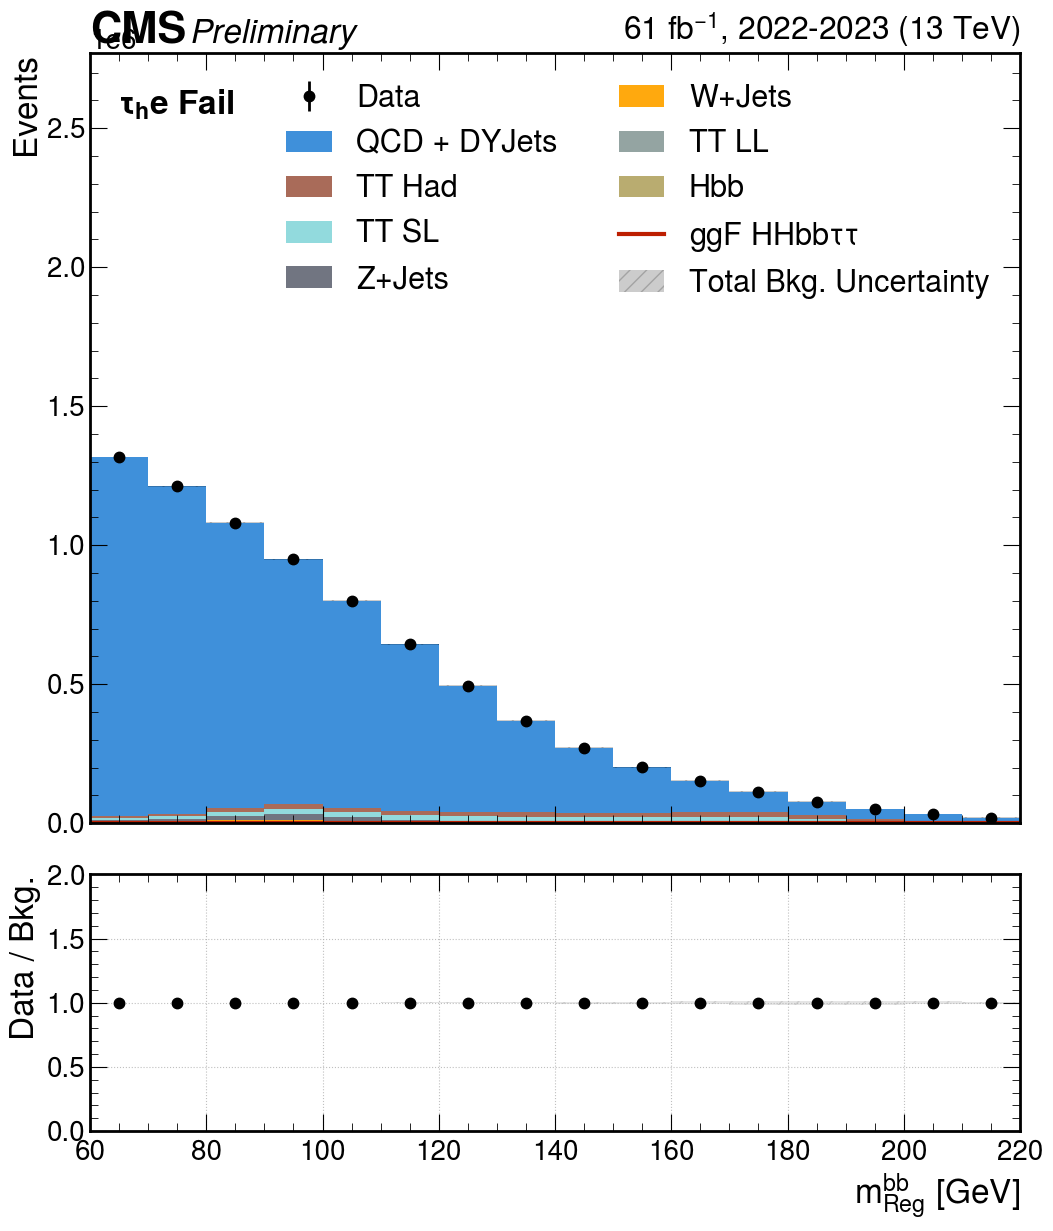

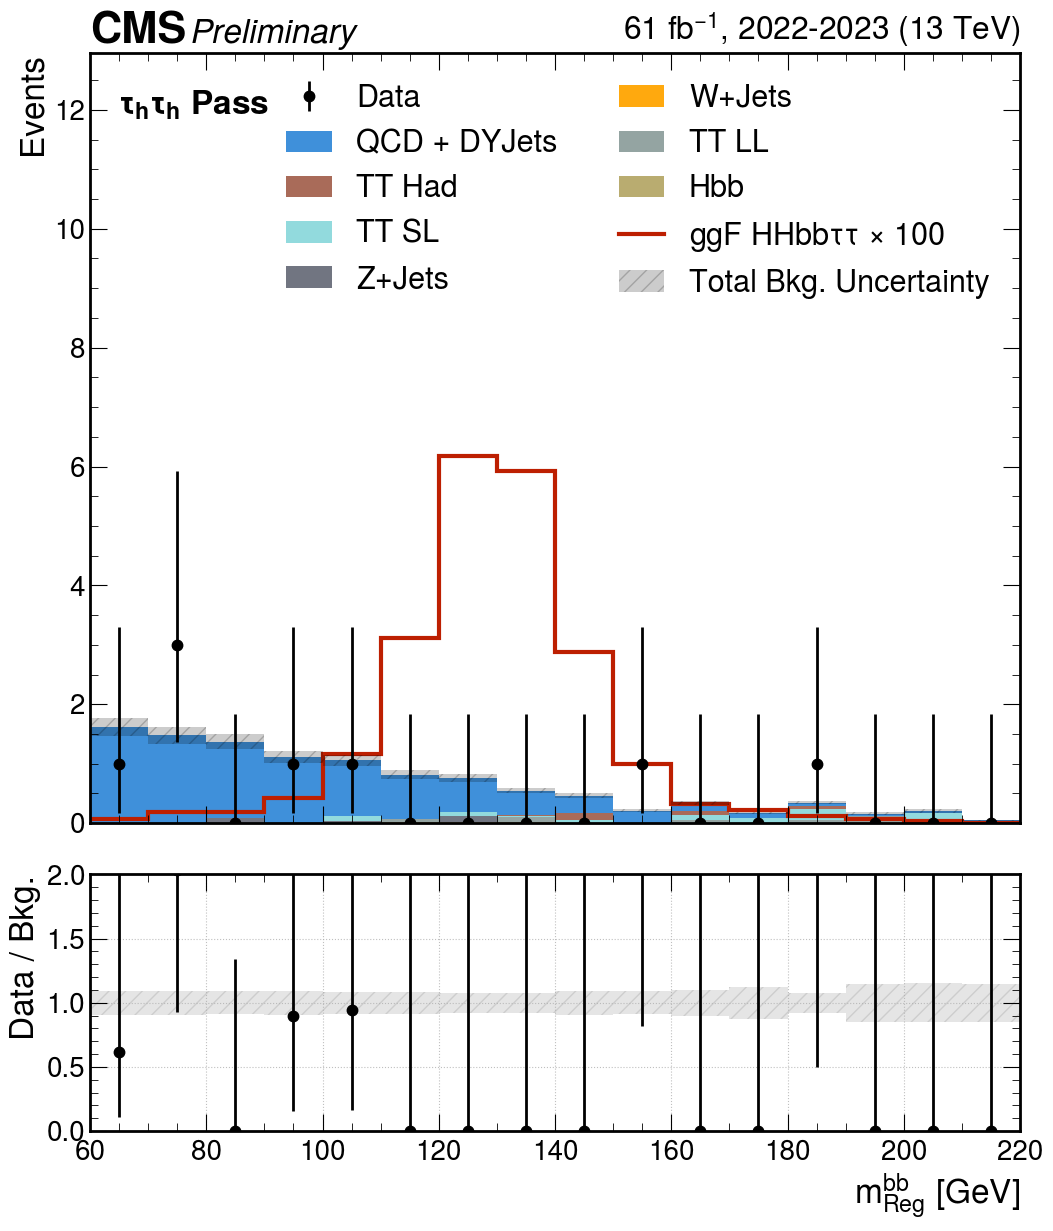

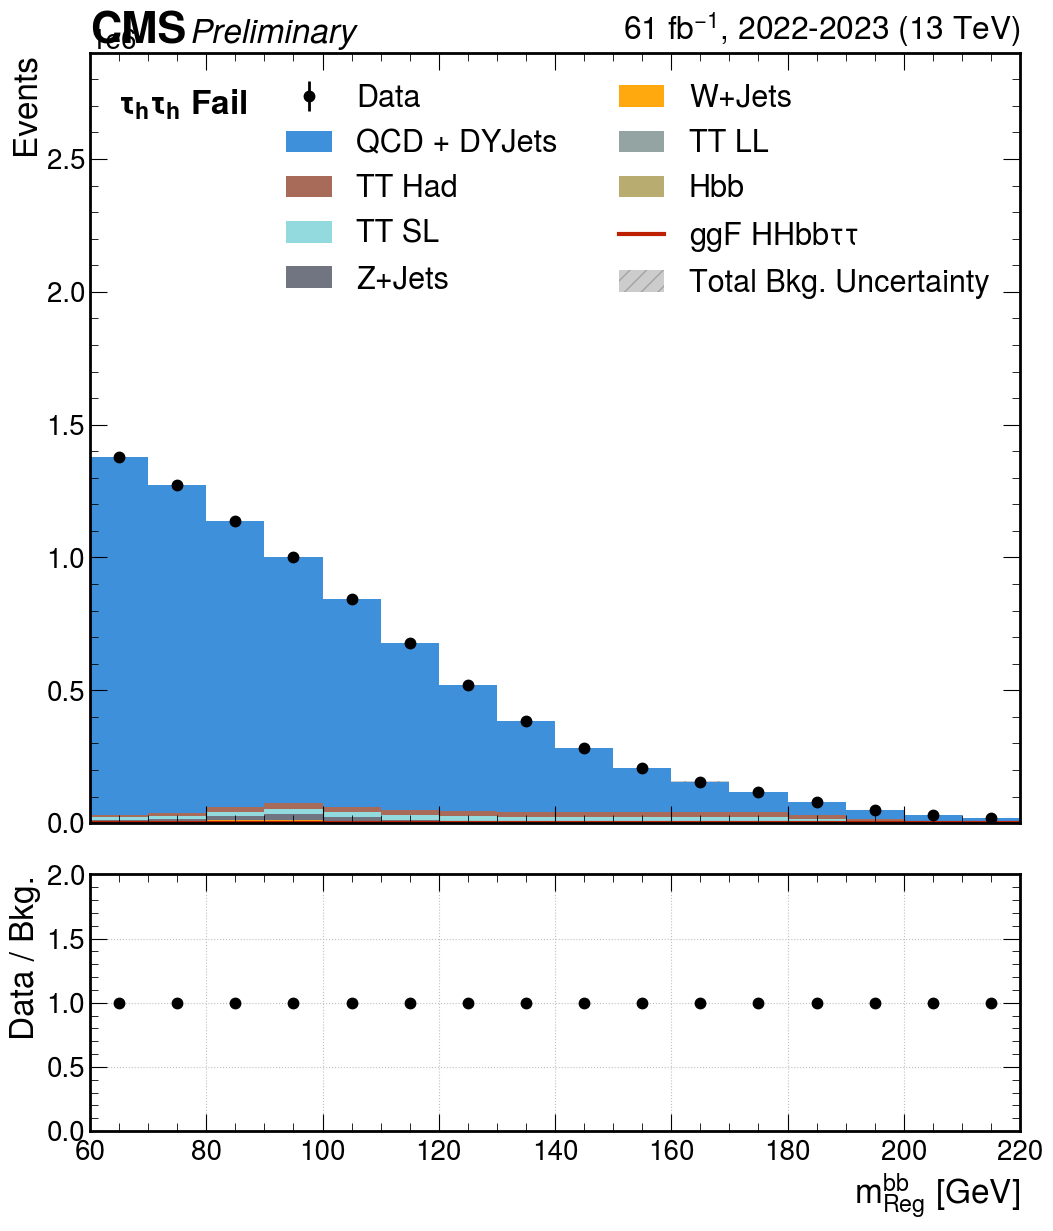

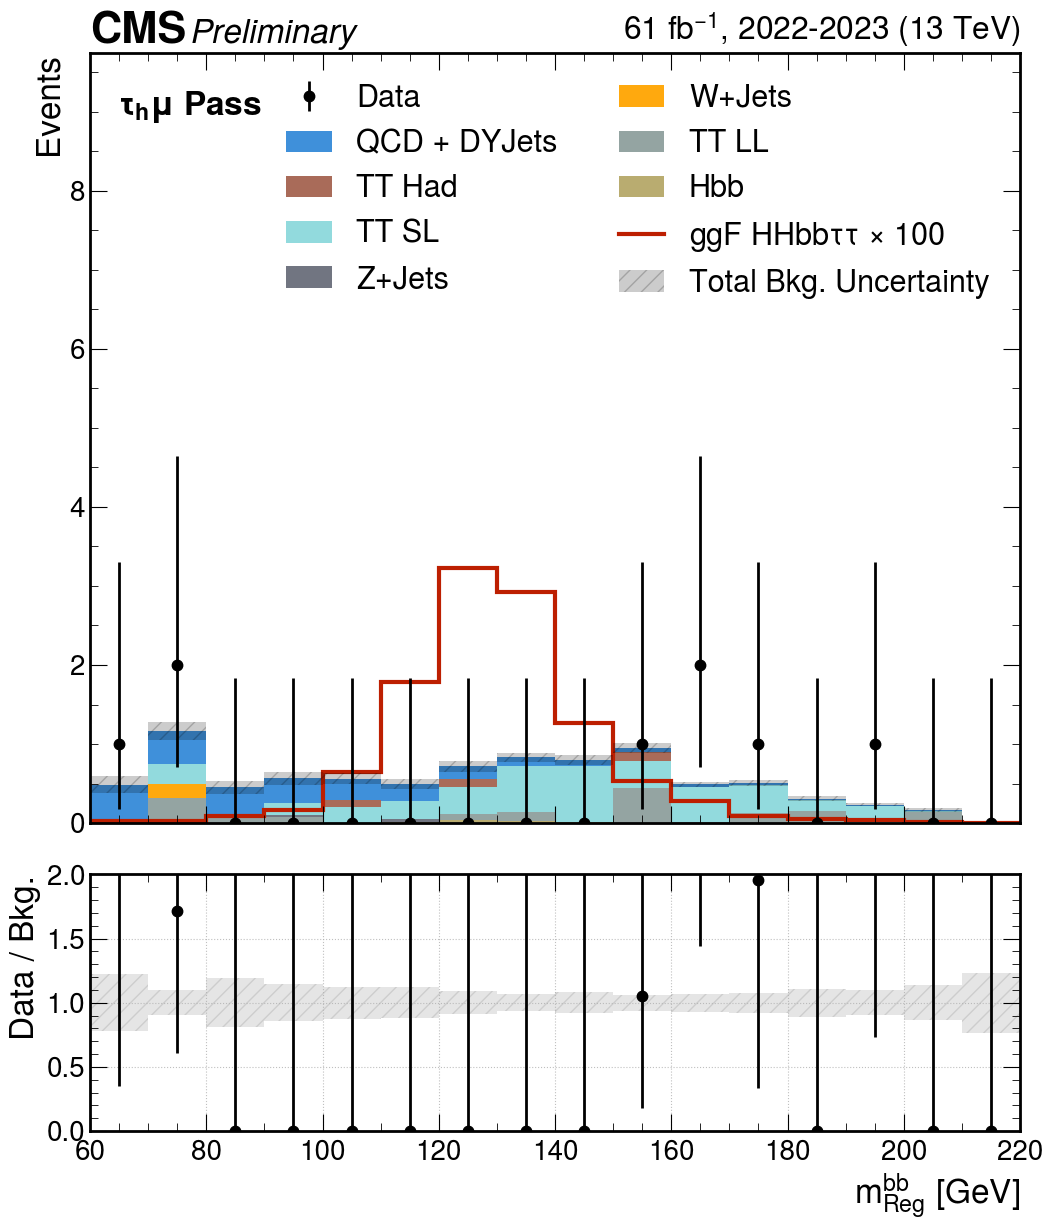

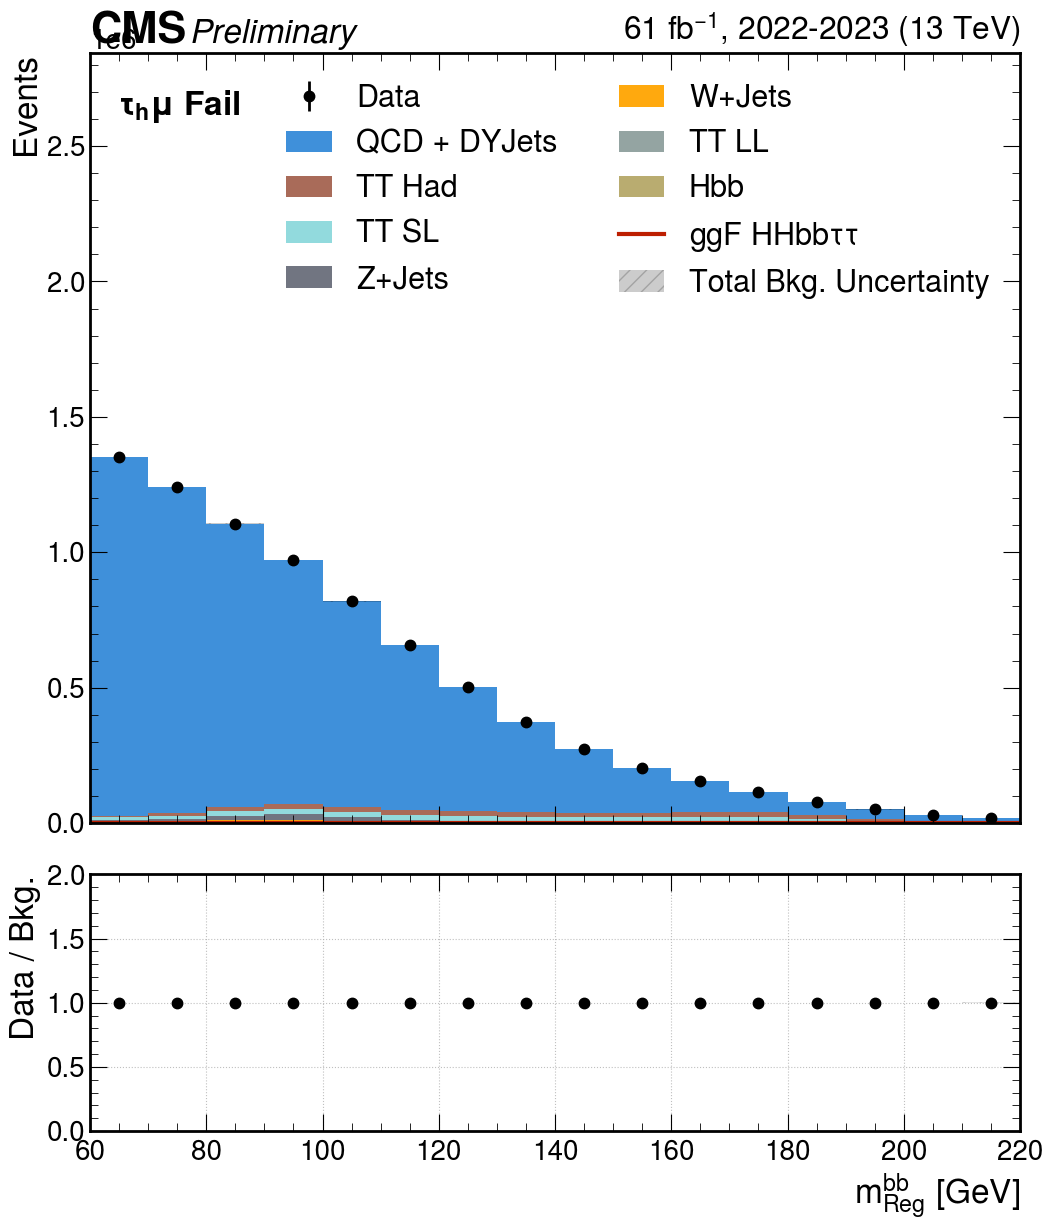

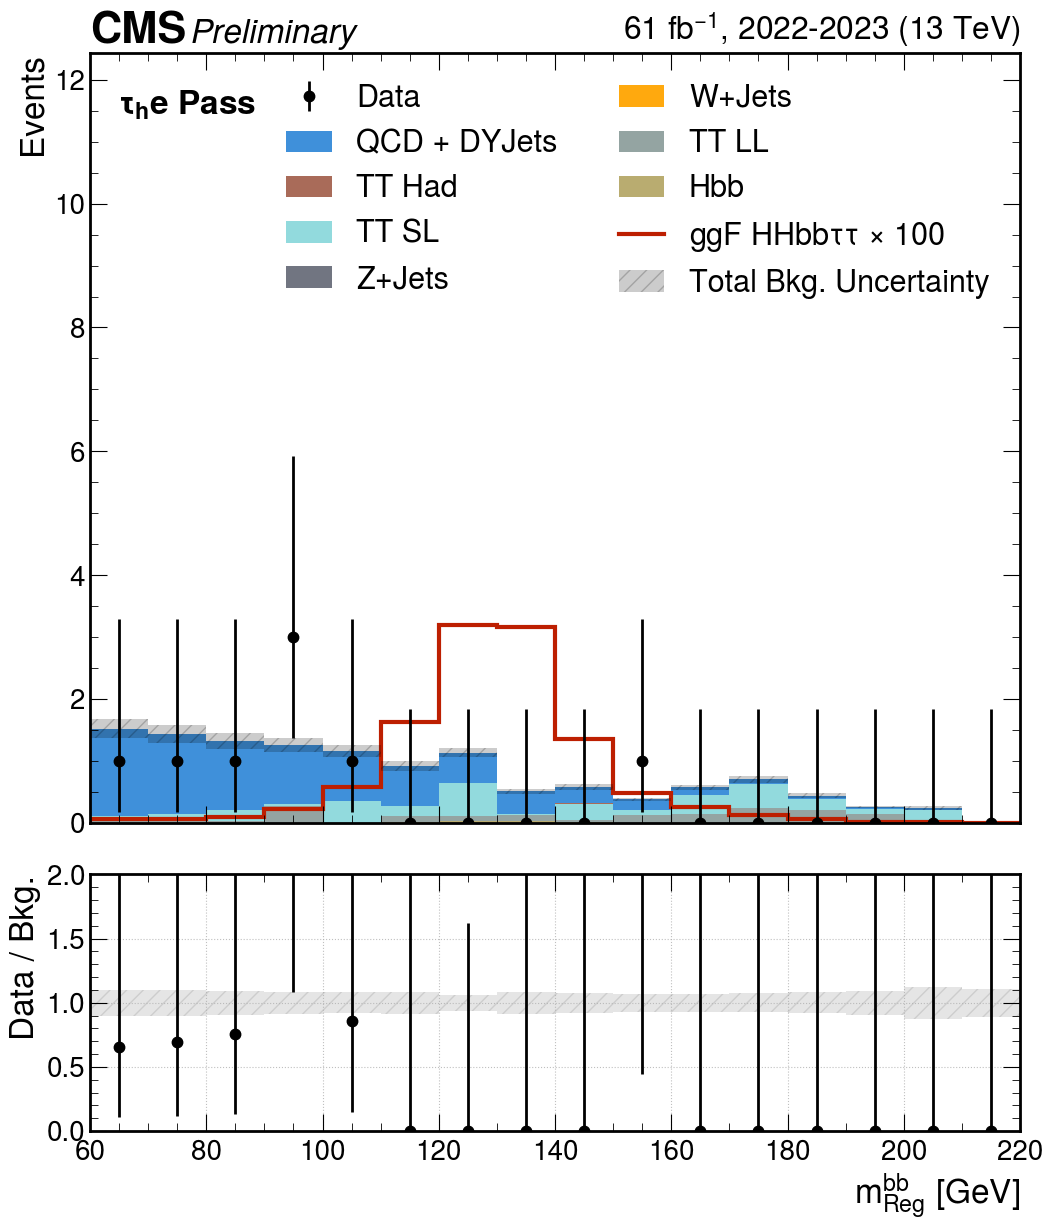

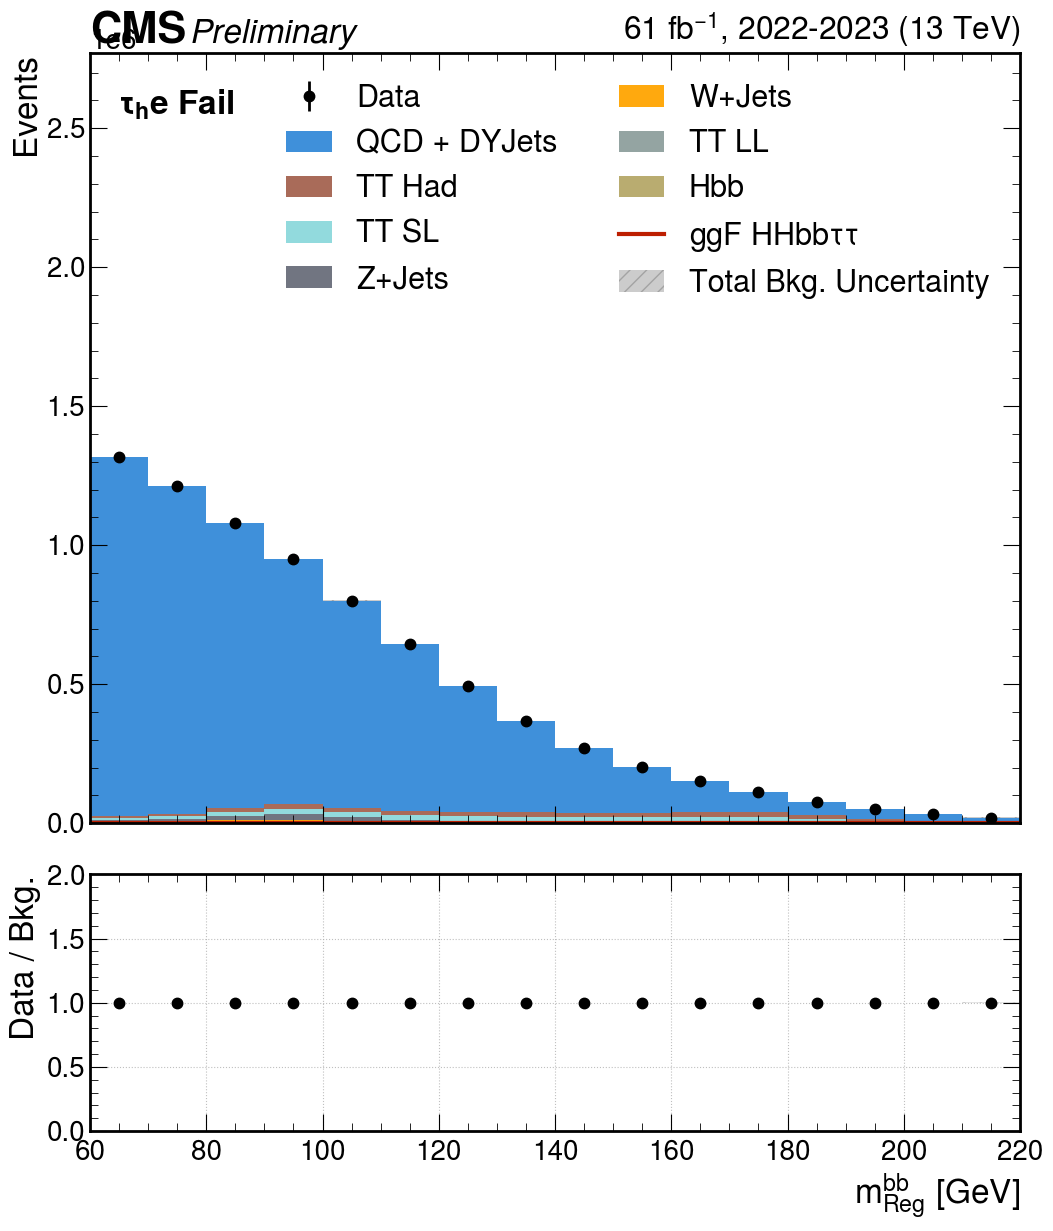

In [17]:
# ylims = {"hhpass": 1, "passvbf": 11, "fail": 7e5}
sig_scale_dict = {"bbtt": 100}

(plot_dir / "preliminary").mkdir(exist_ok=True, parents=True)
(plot_dir / "final").mkdir(exist_ok=True, parents=True)

for prelim, plabel, pplotdir in zip([True, False], ["Preliminary", ""], ["preliminary", "final"]):
    for shape, shape_label in shapes.items():
        # if shape != "postfit":
        #     continue
        for region, region_label in selection_regions.items():
            pass_region = "pass" in region
            for i, shape_var in enumerate(shape_vars):
                plot_params = {
                    "hists": hists[shape][region],
                    "sig_keys": sig_keys,
                    "bg_keys": pbg_keys,
                    "bg_err": bgerrs[shape][region],
                    "data_err": True,
                    "sig_scale_dict": sig_scale_dict if pass_region else None,
                    "show": True,
                    "year": "2022-2023",
                    # "ylim": ylims[region],
                    # "title": f"{shape_label} {region_label}",
                    "region_label": region_label,
                    "name": f"{plot_dir}/{pplotdir}/{pplotdir}_{shape}_{region}_{shape_var.var}.pdf",
                    "ratio_ylims": [0, 2],
                    "cmslabel": plabel,
                    "leg_args": {"fontsize": 22, "ncol": 2},
                    "channel": CHANNELS[region[:2]],
                }

                plotting.ratioHistPlot(**plot_params)

        # break
    break

## QCD Transfer Factor

In [ ]:
import matplotlib.ticker as mticker
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

In [ ]:
ylims = {"passggf": 1e-4, "passvbf": 1e-5}
tfs = {}

for region, region_label in selection_regions.items():

    if region == "fail":
        continue

    tf = (
        hists["postfit"][region]["qcddy", ...] / hists["postfit"][region[:2] + "fail"]["qcddy", ...]
    )

    print(tf)

    tfs[region] = tf

    hep.histplot(tf)
    plt.title(f"{region_label} Region")
    plt.ylabel("QCD Transfer Factor")
    plt.xlim([50, 250])
    plt.ylim([0, 1e-4])
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    plt.savefig(f"{plot_dir}/{region}_QCDTF.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
tf = tfs["passvbf"]
slope = (tf.view()[-1] - tf.view()[0]) / (245 - 55)
yint = tf.view()[0] - slope * 55
print(slope, yint)